### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

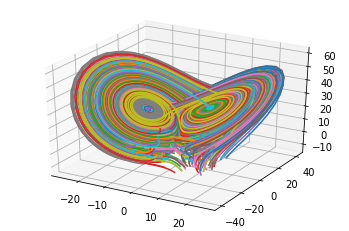

In [2]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D


dt = 0.01  # time step size
T = 8  # total simulation time per initial condition
t = np.arange(start=0, stop=T, step=dt)
num_trajectories = 500  # number of trajectories to simulate

# Set parameters of the lorenz system (rho set later)
b = 8/3
sig = 10


def lorenz(t, x, rho):
    global b, sig
    return [sig * (x[1] - x[0]),  rho * x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]


for i, rho in enumerate([28]): # 10, 28, 40
    fig = plt.figure(i)
    ax = fig.gca(projection='3d')
    for j in range(num_trajectories):
        x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

        # Pass in initial conditions and relative/absolute tolerance
        y_vals = scipy.integrate.odeint(func = lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)
        
        
        if j == 0 and i == 0:
            inputs = y_vals[:-1, :]
            outputs = y_vals[1:, :]
        else:
            inputs = np.vstack((inputs, y_vals[:-1, :]))
            outputs = np.vstack((outputs, y_vals[1:, :]))

        ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])


    plt.show(block=True)


# Inputs stores the (x,y,z) at each time t and Outputs stores the (x,y,z) at each time (t+1) ; the two are just staggered


### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [11]:
from keras.models import Sequential
from keras.layers import Dense

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(10, activation='relu', input_shape = (3,)))
model.add(Dense(40, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


In [12]:
model.fit(inputs, outputs, 
         epochs=500,
         batch_size=100,
         shuffle=False, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 319600 samples, validate on 79900 samples
Epoch 1/500
319600/319600 [==============================] - 3s 11us/step - loss: 25.9165 - val_loss: 3.3727
Epoch 2/500
319600/319600 [==============================] - 3s 10us/step - loss: 1.4191 - val_loss: 0.8389
Epoch 3/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.5181 - val_loss: 0.5984
Epoch 4/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.3194 - val_loss: 0.4702
Epoch 5/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.2432 - val_loss: 0.3883
Epoch 6/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.2121 - val_loss: 0.3209
Epoch 7/500
319600/319600 [==============================] - 4s 12us/step - loss: 0.1812 - val_loss: 0.2611
Epoch 8/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.1575 - val_loss: 0.2140
Epoch 9/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.

319600/319600 [==============================] - 3s 10us/step - loss: 0.0460 - val_loss: 0.0766
Epoch 76/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0457 - val_loss: 0.0747
Epoch 77/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0455 - val_loss: 0.0724
Epoch 78/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0452 - val_loss: 0.0712
Epoch 79/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0451 - val_loss: 0.0682
Epoch 80/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0445 - val_loss: 0.0664
Epoch 81/500
319600/319600 [==============================] - 4s 11us/step - loss: 0.0441 - val_loss: 0.0651
Epoch 82/500
319600/319600 [==============================] - 4s 11us/step - loss: 0.0439 - val_loss: 0.0643
Epoch 83/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0434 - val_loss: 0.0643
Epoch 84/500
319600/319600 [====

Epoch 150/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0367 - val_loss: 0.0765
Epoch 151/500
319600/319600 [==============================] - 4s 11us/step - loss: 0.0356 - val_loss: 0.0652
Epoch 152/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0370 - val_loss: 0.0761
Epoch 153/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0357 - val_loss: 0.0670
Epoch 154/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0361 - val_loss: 0.0748
Epoch 155/500
319600/319600 [==============================] - 4s 11us/step - loss: 0.0356 - val_loss: 0.0684
Epoch 156/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0365 - val_loss: 0.0788
Epoch 157/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0350 - val_loss: 0.0705
Epoch 158/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0359 - val_loss: 0.0931
Epoch 159/

319600/319600 [==============================] - 3s 10us/step - loss: 0.0332 - val_loss: 0.0509
Epoch 225/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0330 - val_loss: 0.0624
Epoch 226/500
319600/319600 [==============================] - 4s 11us/step - loss: 0.0336 - val_loss: 0.0490
Epoch 227/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0324 - val_loss: 0.0590
Epoch 228/500
319600/319600 [==============================] - 4s 12us/step - loss: 0.0330 - val_loss: 0.0488
Epoch 229/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0325 - val_loss: 0.0522
Epoch 230/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0326 - val_loss: 0.0486
Epoch 231/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0328 - val_loss: 0.0470
Epoch 232/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0326 - val_loss: 0.0489
Epoch 233/500
319600/319

319600/319600 [==============================] - 3s 10us/step - loss: 0.0300 - val_loss: 0.0529
Epoch 299/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0299 - val_loss: 0.0579
Epoch 300/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0299 - val_loss: 0.0493
Epoch 301/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0302 - val_loss: 0.0534
Epoch 302/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0296 - val_loss: 0.0587
Epoch 303/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0300 - val_loss: 0.0610
Epoch 304/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0298 - val_loss: 0.0595
Epoch 305/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0298 - val_loss: 0.0549
Epoch 306/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0298 - val_loss: 0.0565
Epoch 307/500
319600/319

319600/319600 [==============================] - 3s 10us/step - loss: 0.0287 - val_loss: 0.0532
Epoch 373/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0286 - val_loss: 0.0530
Epoch 374/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0287 - val_loss: 0.0522
Epoch 375/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0288 - val_loss: 0.0532
Epoch 376/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0285 - val_loss: 0.0522
Epoch 377/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0287 - val_loss: 0.0520
Epoch 378/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0287 - val_loss: 0.0518
Epoch 379/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0283 - val_loss: 0.0541
Epoch 380/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0287 - val_loss: 0.0539
Epoch 381/500
319600/319

319600/319600 [==============================] - 3s 10us/step - loss: 0.0271 - val_loss: 0.0560
Epoch 447/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0271 - val_loss: 0.0560
Epoch 448/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0270 - val_loss: 0.0558
Epoch 449/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0271 - val_loss: 0.0579
Epoch 450/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0271 - val_loss: 0.0559
Epoch 451/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0269 - val_loss: 0.0538
Epoch 452/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0271 - val_loss: 0.0592
Epoch 453/500
319600/319600 [==============================] - 3s 11us/step - loss: 0.0270 - val_loss: 0.0555
Epoch 454/500
319600/319600 [==============================] - 3s 10us/step - loss: 0.0270 - val_loss: 0.0574
Epoch 455/500
319600/319

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

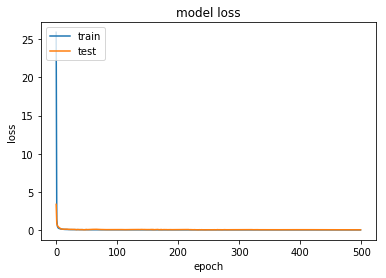

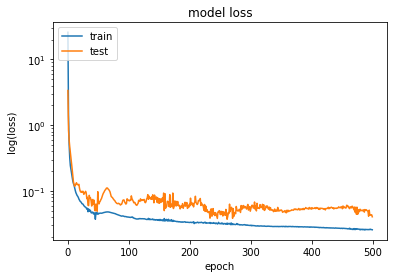

In [13]:
%matplotlib inline

# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

Text(0.5, 0, 'z coord')

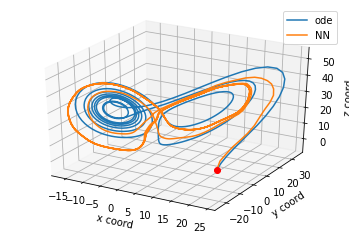

In [16]:
%matplotlib inline

y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

rho = 28

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')

    


In [8]:
#save_me = y0